In [1]:
import os, hdbscan, itertools, time
# import hdbscan
# import itertools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats as st

from sklearn import preprocessing
from sklearn import metrics, mixture, random_projection
from sklearn.manifold import MDS

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD, SparsePCA, FastICA

from sklearn.metrics import silhouette_samples, silhouette_score, consensus_score
from sklearn.decomposition import RandomizedPCA, PCA, KernelPCA, IncrementalPCA, FactorAnalysis
from sklearn.cross_validation import train_test_split
from sklearn.cluster import DBSCAN, estimate_bandwidth, MeanShift, KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph

from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
import warnings

# Utiles

In [2]:
def plot_cls(name, data, labels, alpha=.5, centers=[]):
    name_plot = name + " " + str(np.random.randint(1000))
    colores = ["r","c","b","g","w","brown"]
    col = [colores[x] for x in labels]
    fig = plt.figure(name_plot, figsize=(9,6))
    ax = Axes3D(fig)
    ax.set_title("Clusters por "+name)
    grupos = data.groupby("clase")
    for i, (name, group) in enumerate(grupos):
        c = colores[i]
        ax.scatter(group[0], group[1], group[2], marker='o', c=c, alpha=alpha,
                   label="clase:{0}({1} items)".format(name, group.shape[0]))
    if len(centers)>0:
        for i, c in enumerate(centers):
            ax.text(c[0], c[1], c[2], "c %d"%i,bbox=dict(
                    facecolor='white', alpha=.5, edgecolor='black', boxstyle='round'))
    ax.legend(loc=4)
    plt.show()

def clases_bolsa(data):
    data.index = new_index
    bolsas = [[] for _ in range(12)]
    for i, j in itertools.product(range(12), range(10)):
        ind = "Bolsa {0}-{1}".format(i+1, j+1)
        if ind not in data.index:
            continue
        valor = data.loc[ind]["clase"]
        bolsas[i].append(valor)

    resultados_por_bolsa = pd.DataFrame(columns=["Clase"])
    nombre_bolsas = []
    for i, b in enumerate(bolsas):
        nombre_bolsas.append("Bolsa {}".format(i+1))
        resultados_por_bolsa.loc[i] = [st.mode(b)[0][0]]
    resultados_por_bolsa.index = nombre_bolsas
#     resultados_por_bolsa.to_csv("Resultados_x_bolsa.csv", sep="\t")
    display(resultados_por_bolsa.T)

new_index = []
for i, j in itertools.product(range(12),range(10)):
    new_index.append('Bolsa {0}-{1}'.format(i+1,j+1))
new_index.remove('Bolsa 4-3')

In [42]:
pca_totales = pd.DataFrame()
datos = []
files = os.listdir("SojaData/")

for i in range(15):
    pca_temp = np.array([])
    for j in range(12):

        n_file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i, j)
        if n_file not in files:
            continue
        df = pd.read_csv("SojaData/{0}".format(n_file), header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
#         pca = RandomizedPCA(n_components=1, random_state=10)
        pca = KernelPCA(n_components=1, kernel="rbf")
        pca_file = pca.fit_transform(  preprocessing.scale(df)  )
        pca_file = np.array(pca_file)
        
        pca_file = pca_file.reshape(1, -1)
        datos = np.append(datos, pca_file)
#         pca_temp = np.append(pca_temp, pca_file_n)
        pca_totales = pca_totales.append(pd.DataFrame(pca_file), ignore_index=True)

# pca_totales.dropna(axis=0, how="all", inplace=True)
pca_totales.fillna(value=0,axis=0, inplace=True)
pca_totales.shape

(119, 501)

In [43]:
va_tr = VarianceThreshold( .8*(1-.8) ) 
pca_totales_2 = va_tr.fit_transform(pca_totales)
pca_totales_2.shape

(119, 384)

Variacion: 0.9997692020982472
MS Score: 0.975949342919193


<IPython.core.display.Javascript object>


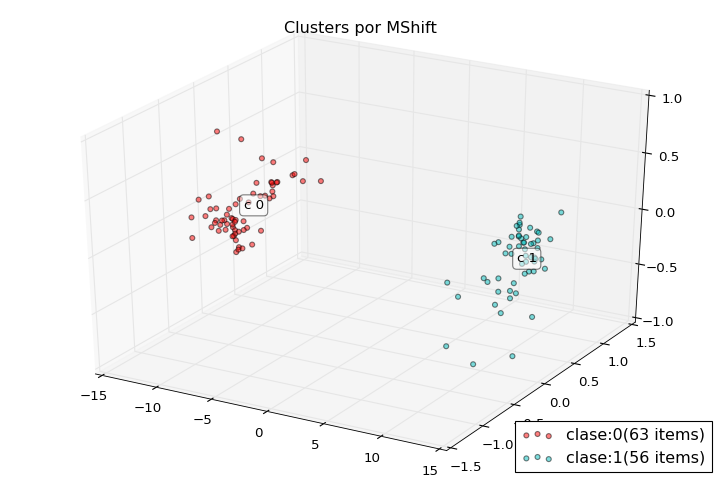

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


KM Score: 0.7209930708386271


<IPython.core.display.Javascript object>


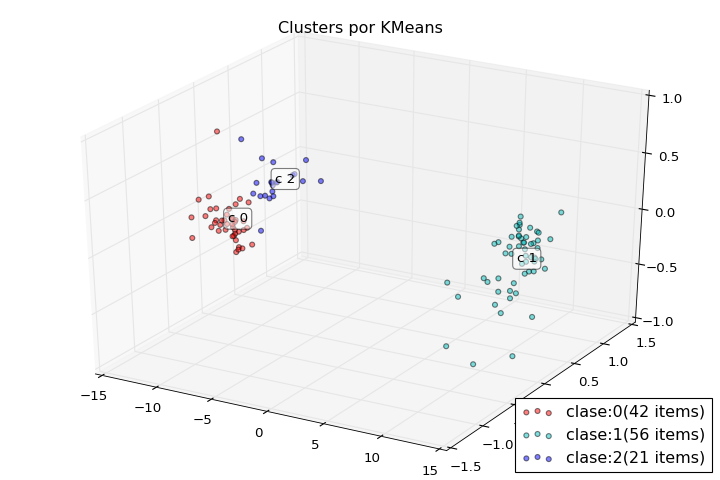

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0


In [44]:
pca_i = PCA(n_components=3)
# pca_i = KernelPCA(n_components=3, kernel="rbf")
datos = pca_i.fit_transform(pca_totales_2)
print("Variacion: {}".format(np.sum(pca_i.explained_variance_ratio_)))
d_plots = pd.DataFrame(datos)

b_width = estimate_bandwidth(datos, quantile=0.5, n_samples=datos.shape[0])
ms_ = MeanShift(bandwidth=b_width, bin_seeding=True)
ms_cls = ms_.fit_predict(datos)
d_plots["clase"] = ms_cls
ms_score = silhouette_score(datos, ms_cls)
print("MS Score: {}".format(ms_score))
plot_cls("MShift", d_plots, ms_cls, centers=ms_.cluster_centers_)
clases_bolsa(d_plots)

km_ = KMeans(n_clusters=3, random_state=10)
# km_.fit(datos)
km_cls = km_.fit_predict(datos)
km_score = silhouette_score(datos, km_cls)
print("KM Score: {}".format(km_score))
d_plots["clase"] = km_cls
plot_cls("KMeans", d_plots, km_cls, centers=km_.cluster_centers_)
clases_bolsa(d_plots)

In [48]:
# for i, b in enumerate(datos):
#     print(i+1, km_.predict(b))

# d_plots[d_plots > 0][0:1]
d_plots["clase"]

Bolsa 1-1      0
Bolsa 1-2      1
Bolsa 1-3      0
Bolsa 1-4      1
Bolsa 1-5      0
Bolsa 1-6      0
Bolsa 1-7      0
Bolsa 1-8      1
Bolsa 1-9      1
Bolsa 1-10     0
Bolsa 2-1      2
Bolsa 2-2      1
Bolsa 2-3      1
Bolsa 2-4      1
Bolsa 2-5      1
Bolsa 2-6      1
Bolsa 2-7      0
Bolsa 2-8      1
Bolsa 2-9      0
Bolsa 2-10     1
Bolsa 3-1      0
Bolsa 3-2      0
Bolsa 3-3      0
Bolsa 3-4      2
Bolsa 3-5      2
Bolsa 3-6      0
Bolsa 3-7      0
Bolsa 3-8      1
Bolsa 3-9      1
Bolsa 3-10     1
              ..
Bolsa 10-1     2
Bolsa 10-2     2
Bolsa 10-3     1
Bolsa 10-4     1
Bolsa 10-5     2
Bolsa 10-6     2
Bolsa 10-7     2
Bolsa 10-8     2
Bolsa 10-9     1
Bolsa 10-10    0
Bolsa 11-1     2
Bolsa 11-2     1
Bolsa 11-3     1
Bolsa 11-4     1
Bolsa 11-5     1
Bolsa 11-6     0
Bolsa 11-7     2
Bolsa 11-8     0
Bolsa 11-9     1
Bolsa 11-10    1
Bolsa 12-1     2
Bolsa 12-2     0
Bolsa 12-3     0
Bolsa 12-4     1
Bolsa 12-5     1
Bolsa 12-6     0
Bolsa 12-7     0
Bolsa 12-8    